In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import re
import itertools as it

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import GPy

import shared

In [3]:
inp = pd.read_csv("../data/Botrytis_Data.csv", index_col=[0,1], dtype=str)
inp.index.names = ['reporter','gene']
inp.columns = pd.MultiIndex.from_tuples(
    [(a[1]+':'+a[2], float(re.sub(r' +hours$','',a[0])))
     for a in [x.split(':') for x in inp.columns]],
    names=["sample,replicate","hours"])
inp = inp.astype(float)

In [4]:
inp2 = inp.set_index(pd.Index(b for (a,b) in inp.index))
inp2 = (inp2 - np.mean(inp2.values)) / np.std(inp2.values)
inp2.sortlevel(inplace=True,axis=1)
inp2.to_csv('../data/Botrytis_Data-twoheader.csv')

In [5]:
inp2 = pd.read_csv("../data/Botrytis_Data-twoheader.csv",header=[0,1],index_col=0)
inp2.columns = pd.MultiIndex.from_tuples([(a,float(b)) for a,b in inp2.columns],names=inp2.columns.names)
inp2

sample,replicate Botrytis:A                                                    \
hours                    2         4         6         8         10        12   
AT4G34000         -0.053079 -0.304875 -0.483745 -0.156508 -0.202809  0.338516   
AT3G19290         -0.504459 -0.251477 -0.257191 -1.462210 -0.943728 -0.206392   
AT2G40220          0.411811  0.220898  0.191625  0.207554  0.223502  0.131607   
AT2G36270         -1.463447 -1.424161 -1.100205 -1.249579 -1.427928 -1.629272   
AT1G01480         -1.996341 -1.221054 -1.210107 -4.027722 -1.225565 -1.751466   
AT2G37620         -0.088654 -0.394301 -0.457610 -0.373040 -0.445399 -0.511132   
AT3G01420         -1.598808 -1.369368 -1.397140 -1.214072 -1.149628 -2.057762   
AT1G52890          1.076062 -0.028432 -0.373933 -0.309916 -0.407319 -0.087757   
AT1G61110         -1.069074 -1.519436 -1.264536 -1.385842 -1.514637 -1.014876   
AT3G56530         -0.129513 -0.637662 -0.901596 -1.181431 -0.707153 -0.946698   
AT5G13180         -0.094500  0.379073 -0.171551  0.130391  0.194030  0.227373   
AT5G39610         -0.341226 -0.854083 -0.782162 -1.069271 -0.929156 -0.570104   
AT5G63790          1.617329  1.877462  1.461760  1.262854  1.492687  1.383130   
AT5G62000         -0.326172 -0.136350 -0.433258 -0.467591 -0.485819 -0.198225   
AT3G51910         -0.087139 -0.126151  0.140287  0.142416 -0.000418  0.068965   
AT1G06160         -2.093805 -1.357173 -0.620591 -2.185862 -0.565054 -2.132244   
AT1G25550          0.329375  0.178728  0.177907  0.449700  0.462199  0.744238   
AT1G35560          0.765180  0.525214  1.072333  1.313758  1.304460  0.983638   
AT1G79320         -1.226133 -1.374451 -0.617979 -1.964033 -1.245514 -1.650820   
AT2G18300         -1.156067 -1.036831 -0.796430 -0.644955 -1.139068 -1.072332   
AT2G24430         -0.946795 -0.714301 -0.914190 -0.717744 -0.851772 -1.095010   
AT2G28510          0.783236  0.314319  0.549218  0.979053  0.738894  0.334388   
AT2G40340          0.470927  0.125073 -0.272082 -0.255254 -0.486245 -0.457054   
AT2G45220         -1.172412 -0.744565 -0.610359 -0.715455 -0.653901 -0.574097   
AT2G45800         -0.660066 -0.256998 -0.452609 -0.245613 -0.298711 -0.271220   
AT3G13040          0.114578  0.225685  0.317109  0.336910  0.381787  0.308605   
AT3G23220          0.149205  0.045996 -0.002326 -0.175677 -0.054133 -0.022954   
AT3G28320         -1.885149 -0.995452 -2.514919 -1.106366 -1.380070 -0.852568   
AT3G57600         -0.411008 -0.821670 -0.787537 -2.163714 -1.356259 -2.466610   
AT3G58120         -0.966789 -0.941488 -1.059747 -0.778373 -0.982623 -1.147615   
...                     ...       ...       ...       ...       ...       ...   
AT3G06490         -0.846206 -1.438199 -1.016496 -1.041417 -1.450963 -1.247764   
AT1G48000          0.553828  0.499802 -0.058947  0.561070  0.372383  0.397484   
AT2G47190          0.252789  0.170199 -0.382689 -0.078355 -0.047509  0.058331   
AT3G14440         -1.350521 -1.001317 -0.891167 -1.557734 -0.870131 -0.694741   
AT1G75390         -0.017519  0.031125  0.042805  0.607981  0.556756  0.389393   
AT3G19580         -1.004504 -1.313604 -0.837124 -0.436015 -0.319970  0.048065   
AT1G50420          1.604312  1.473405  1.808832  1.670627  1.435975  0.980670   
AT3G02150         -0.089029 -0.255957 -0.311050 -0.275321 -0.400791 -0.262407   
AT3G15500         -1.062787 -1.334840 -1.011394 -2.499134 -1.098655 -1.711098   
AT3G17790          1.574165  1.020347  1.027803  1.905586  1.437140  1.735985   
AT3G48590         -0.228560  0.126825 -0.389967 -0.104543 -0.088072  0.082619   
AT4G24540         -0.812004  0.044463 -0.022452 -0.070339  0.259625  0.105995   
AT5G53980         -1.672817 -1.414357 -1.381492 -2.235975 -1.275161 -1.494812   
AT2G38470         -0.285070 -0.268739 -0.523985 -0.361795 -0.392952 -0.135683   
AT4G13250          1.163715  1.477677  0.817054  0.702874  0.445002  0.274111   
AT5G06960         -0.368417 -0.359103 -0.607226 -0.292274 -0.508712 -0.315587   
AT5G61270         -1.391565 -0.

In [6]:
n = [a for a,b in inp2.columns.values]
i = np.flatnonzero(np.array([a==b for a,b in zip(n, n[1:])]))
inpX = inp2.iloc[:,i]
inpY = inp2.iloc[:,i+1]

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,0.207771047081,+ve,,
rbf.lengthscale,1.9316836712,+ve,,
Gaussian_noise.variance,0.0205263533115,+ve,,


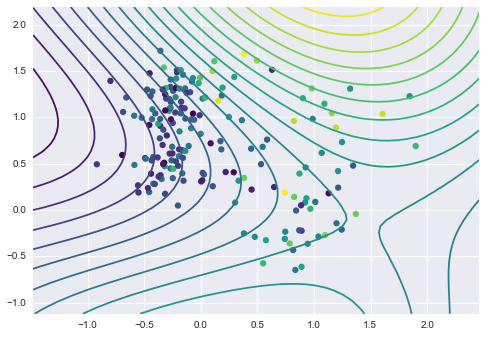

In [13]:
m = GPy.models.GPRegression(inpX.loc[["AT5G47230","AT1G22070"]].T, inpY.loc[["AT2G40220"]].T)
m.optimize()
m.plot(cmap="viridis")
m